In [2]:
from langchain_openai import ChatOpenAI
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display


from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_text_splitters import HTMLSectionSplitter


OPENAI_API_KEY = ''

import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [4]:
documents_path = '../data/financial_reports/earning_call_scripts/Transcripts/AMZN'

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=100,
    length_function=len,
    separators=[
        "\n\n",
        "\n",
        " ",
        ".",
        ",",
        "\u200b",  # Zero-width space
        "\uff0c",  # Fullwidth comma
        "\u3001",  # Ideographic comma
        "\uff0e",  # Fullwidth full stop
        "\u3002",  # Ideographic full stop
        "",
        "--------------------------------------------------------------------------------"
    ],
)

In [6]:
import string

def has_high_percentage_of_punctuation(input_string, threshold=0.2):
    """
    Check if a string has a high percentage of punctuation marks.
    
    Parameters:
    - input_string (str): The string to check.
    - threshold (float): The percentage threshold (e.g., 0.3 for 30%).
    
    Returns:
    - bool: True if the percentage of punctuation marks exceeds the threshold, otherwise False.
    """
    # Count the number of punctuation marks in the string
    punctuation_count = sum(1 for char in input_string if char in string.punctuation)
    
    # Calculate the percentage of punctuation marks
    total_chars = len(input_string)
    if total_chars == 0:
        return False  # Avoid division by zero
    
    punctuation_percentage = punctuation_count / total_chars
    
    # Check if the percentage exceeds the threshold
    return punctuation_percentage > threshold

In [7]:
from langchain_core.documents import Document
from datetime import datetime
import re


list_of_documents = []
metadata = []
just_documents = []

for doc in os.listdir(documents_path):
    document = open(os.path.join(documents_path, doc), 'r').read()
    split_text = text_splitter.split_text(document)
    for s in split_text:
        if len(s.split()) < 30:
            continue
        if has_high_percentage_of_punctuation(s):
            continue
        else:
            lang_doc = Document(page_content=re.sub(r'-{3,}', ' ', s))
            date = doc.split('-')[:-1]
            date = datetime.strptime(' '.join(date), '%Y %b %d').timestamp()
            date = int(date)
            
            lang_doc.metadata = {'company': 'AMZN', 'date': date}
            metadata.append({'company': 'AMZN', 'date': date})
            list_of_documents.append(lang_doc)
            just_documents.append(re.sub(r'-{3,}', ' ', s))


In [8]:
from uuid import uuid4

uuids = [str(uuid4()) for _ in range(len(list_of_documents))]

In [9]:
embeddings = OpenAIEmbeddings()

In [10]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="transcripts",
    embedding_function=embeddings,
    persist_directory="./rag",)

In [11]:
vector_store.add_documents(documents=list_of_documents, ids=uuids)

['efaee67b-115d-4ec4-817b-1deb50ce9a2f',
 'b7c4d715-68a9-471f-b691-f24418865357',
 'c2a8889c-8364-4b40-85b3-a343fcba9435',
 'a74272db-c09c-4fdd-bc2a-ffa9cd3bf3d8',
 '7605c5f1-58f9-4444-8917-ce1d147bb1d6',
 'e4aab907-0ead-46be-b337-353118729fb5',
 'dfe4a0e1-cd62-4a5c-8601-adec23af12e2',
 'c4d83faf-fbfa-4100-9e97-d94c5f74a5f7',
 '98b5b2fc-fc10-46d5-8f76-64a0984d405f',
 '4f3b4a25-f2f3-49ec-b953-d15d91757b85',
 '5002e6e7-1688-4d72-8145-354a72c400e0',
 '37c9fbb1-fd11-4a11-8749-dad3a3d2788e',
 '3e9c15d1-47b4-4869-afc6-209650c202ba',
 '12e38b4d-b661-4b89-bed6-c7507a71f170',
 '6d3b0faf-9b07-4e93-810b-57737b9c2cd9',
 'fc4c9409-c88d-4d04-9eeb-0748257eaab3',
 '58f976d7-e9b9-4ce1-a00f-f7d0f29417a7',
 'b986ab19-909a-4d6a-b51e-4cae59391785',
 '88472b32-5045-47f7-9311-90a98a76f5dd',
 '36719c74-6bdc-4a31-9fbd-a91bc19b7844',
 '8373908e-1236-4098-ad6a-ec1071d17bab',
 'a2bb910b-be4c-48bc-8081-0ba9c38d5fed',
 'c0c375e6-9952-44ff-9b27-ff7c2048f8b7',
 '0db7e9a2-c98e-4894-af92-f5dec5d25e6d',
 'eca6225e-03be-

In [12]:
# Define the retrieval function
def retrieve_documents(query):
    return vector_store.similarity_search(query, k=5)  # Retrieve top 5 relevant documents

retriever = vector_store.as_retriever()

In [13]:
# Define the date range for filtering
start_date = "2016-01-01"
end_date = "2016-08-31"
where_document = {
    "date": {"$gte": int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())} #}, {'date': {"$lte": end_date}}]
}

where_document={"$and": [{ "date": {"$gte": int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())}},
                         { "date": {"$lte": int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())}}
                         ]}



In [14]:
collection_name = "transcrips"
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
embedding_function = OpenAIEmbeddingFunction(api_key=os.environ.get('OPENAI_API_KEY'), model_name='text-embedding-3-small')


client = chromadb.Client()  # Or your specific client configuration
collection = client.get_or_create_collection(name=collection_name, embedding_function=embedding_function)

In [15]:
collection.add(documents=just_documents,
               metadatas=metadata,
               ids=uuids)

In [17]:
query = 'What is Amazon revenue?'
results_with_similarity = collection.query(
    query_texts=query,
    where=where_document,
    n_results=5  # Number of results to return
)

### Define Retriever tool

In [18]:
class Retriever:
    # scratch class
    def __init__(self, db, collection_name):
        self.embedding_function = embedding_function
        self.collection = db.get_or_create_collection(name=collection_name, embedding_function=self.embedding_function)
            
    def retrive(self, query, company=None, start_date=None, end_date=None, n=5):
        where_document = None 
        if start_date and end_date:
            where_document={"$and": [{ "date": {"$gte": int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())}},
                                     { "date": {"$lte": int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())}}
                                     ]}
        
        results_with_similarity = collection.query(
        query_texts=query,
        where=where_document,
        n_results=n
        )
        result_docs = results_with_similarity['documents'][0]
        return result_docs
            

In [62]:
def retriever_function(query, company='AMZN', start_date=None, end_date=None):
    agent = Retriever(client, collection_name)
    result = agent.retrive(query, company, start_date, end_date)
    return result

In [68]:
from langchain.tools import Tool
from langchain.tools.base import StructuredTool

from pydantic import BaseModel, Field

class RetrieverInput(BaseModel):
    query: str = Field(description="Query for the vector database")
    company: str = Field(description="Which company is mentioned in the query?")
    start_date: str = Field(description='Optional. Start date for searching documents in the db.')
    end_date: str = Field(description='Optional. End date for searching documents in the db.')


retriever_tool = StructuredTool(
    name="Retriever",
    args_schema=RetrieverInput,
    description=(
        "Use this tool to get relevant documents for Amazon from transcripts. When dates are specified in the query, convert them into format like 2016-01-10."
    ),
    func=retriever_function,
)


In [69]:
retriever_tool

StructuredTool(name='Retriever', description='Use this tool to get relevant documents for Amazon from transcripts. When dates are specified in the query, convert them into format like 2016-01-10.', args_schema=<class '__main__.RetrieverInput'>, func=<function retriever_function at 0x7f69abf19a80>)

### Define Sentiment tool

In [70]:
from setfit import AbsaModel

def analyze_sentiment(docs: list) -> list:
    model = AbsaModel.from_pretrained(
        'Askinkaty/setfit-finance-aspect',
        'Askinkaty/setfit-finance-polarity',
        spacy_model="en_core_web_sm",
    )
    results = []
    batch_size = 32
    for i in range(0, len(docs), batch_size):
        batch = docs[i:i + batch_size]  # Get the batch as a list
        predictions = model.predict(batch)  # Batch predict
        results.extend(predictions)
    return results


In [71]:
sentiment_tool = Tool(
    name='Sentiment_analyzer',
    description="Use this tool to get sentiment of the document related to some particular companies/products/entities. It will return negative/positive/neutral label.",
    func=analyze_sentiment
)

### Combine tools together

In [73]:
from langchain.tools.retriever import create_retriever_tool
from langgraph.prebuilt import ToolNode
from langchain.tools import BaseTool, StructuredTool, tool
from langgraph.prebuilt import tools_condition
from pydantic import BaseModel, Field
from typing import Optional, Type

tools = [retriever_tool, sentiment_tool]

In [74]:
from langchain.agents import create_tool_calling_agent

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """ You are an expert in finance.
        Use your tools to answer questions. If you do not have a tool to
        answer the question, say so. """

tool_calling_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history", optional=True),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ]
)

llm = ChatOpenAI(temperature=0, streaming=True, model="gpt-3.5-turbo")

tool_runnable = create_tool_calling_agent(llm, tools, prompt  = tool_calling_prompt)
tool_actions = tool_runnable.invoke({"input": "What is Amazon revenue in April 2016?", 'intermediate_steps': []})

In [75]:
def run_tool_agent(state):
    agent_outcome = tool_runnable.invoke(state)

    #this agent will overwrite the agent outcome state variable
    return {"agent_outcome": agent_outcome}

In [78]:
from langgraph.prebuilt.tool_executor import ToolExecutor

# tool executor invokes the tool action specified from the agent runnable
# they will become the nodes that will be called when the agent decides on a tool action.

tool_executor = ToolNode(tools)

# Define the function to execute tools
# This node will run a different tool as specified in the state variable agent_outcome
def execute_tools(state):
    # Get the most recent agent_outcome - this is the key added in the `agent` above
    agent_action = state['agent_outcome']
    if type(agent_action) is not list:
        agent_action = [agent_action]
    steps = []
    # convert single actions to a list
    
    for action in agent_action:
    # Execute the tool
        output = tool_executor.invoke(action)
        print(f"The agent action is {action}")
        print(f"The tool result is: {output}")
        steps.append((action, str(output)))
    # Return the output
    return {"intermediate_steps": steps}

In [79]:
from typing import TypedDict, Annotated,Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain.agents.output_parsers.tools import ToolAgentAction
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
   # The input string from human
   input: str
   # The list of previous messages in the conversation
   chat_history: list[BaseMessage]
   # the state will be overwritten with the latest everytime the agent is run
   agent_outcome: Union[AgentAction, list, ToolAgentAction, AgentFinish, None]

   # Actions should be added to the existing, use `operator.add` to append to the list of the past intermediate steps
   intermediate_steps: Annotated[list[Union[tuple[AgentAction, str], tuple[ToolAgentAction, str]]], operator.add]

In [80]:
def should_continue(data):
    # If the agent outcome is an AgentFinish, then we return `exit` string
    if isinstance(data['agent_outcome'], AgentFinish):
        return "END"
    # Otherwise, an AgentAction is returned
    # This will be used when setting up the graph to define the flow
    else:
        return "CONTINUE"

In [81]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)
workflow.add_node("agent", run_tool_agent)
workflow.add_node("action", execute_tools)

workflow.set_entry_point("agent")

# Add flow logic with static edge.
# Each time a tool is invoked and completed we want to 
# return the result to the agent to assess if task is complete or to take further actions 

workflow.add_edge('action', 'agent')
workflow.add_conditional_edges(
    # starting node
    "agent",
    # logic function to run
    should_continue,

    #mapping between the logic function output and the nodes on the graph
    {
        # If 'continue', proceed to the action node.
        "CONTINUE": "action",
        # Otherwise END
        "END": END
    }
)

In [82]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
app = workflow.compile(checkpointer = memory)

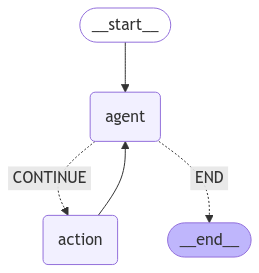

In [83]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [84]:
inputs = {"input": "Tell what is the general sentiment of discussions about AWS in April 2016?", "chat_history": []} 
config = {"configurable": {"thread_id": "1"}}

for s in app.stream(inputs, config = config):
    print(list(s.values())[0])
    print("----")

{'agent_outcome': [ToolAgentAction(tool='Retriever', tool_input={'query': 'AWS', 'company': 'Amazon', 'start_date': '2016-04-01', 'end_date': '2016-04-30'}, log="\nInvoking: `Retriever` with `{'query': 'AWS', 'company': 'Amazon', 'start_date': '2016-04-01', 'end_date': '2016-04-30'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_TljQNml78wTbgX7busgLEJPd', 'function': {'arguments': '{"query":"AWS","company":"Amazon","start_date":"2016-04-01","end_date":"2016-04-30"}', 'name': 'Retriever'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-cff5e1ea-5b15-4b08-a234-1d5e9f1c4808-0', tool_calls=[{'name': 'Retriever', 'args': {'query': 'AWS', 'company': 'Amazon', 'start_date': '2016-04-01', 'end_date': '2016-04-30'}, 'id': 'call_TljQNml78wTbgX7busgLEJPd', 'type': 'tool_call'}])], tool_call_id='call_TljQNml78wTbgX7busgLEJPd')]}
----
The agent action is tool='Retriever' to